## References 
https://github.com/skiehl/wwz

In [313]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [314]:
from matplotlib.colors import LogNorm
from matplotlib import colormaps
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from wwz import WWZ
from wwzplotter import WWZPlotter

In [315]:
plt.rcParams.update({
    'figure.figsize': (16, 4),
    'lines.linestyle': 'None',
    'lines.marker': 'o',
    'lines.markersize': 4,
    })

cmap = colormaps.get_cmap('Greys')

# Load and plot data

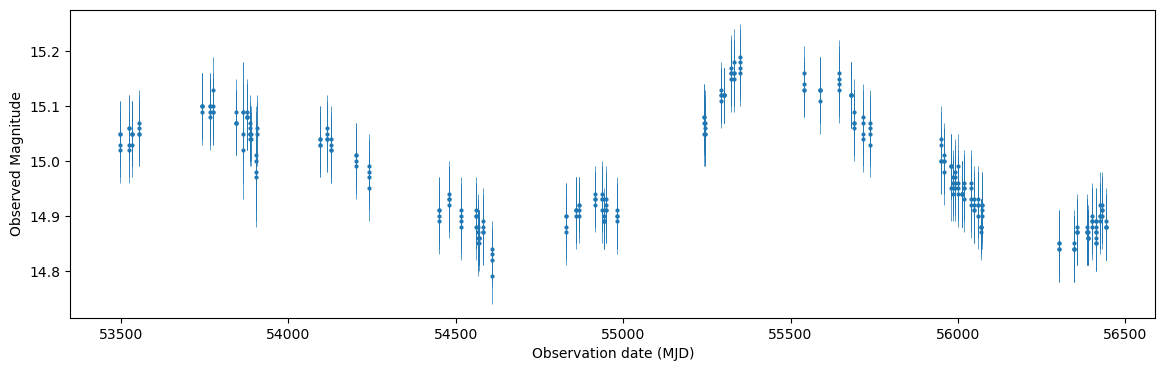

Data total time: 2946.0


In [317]:
import matplotlib.pyplot as plt
lc = np.genfromtxt("data/PG1302_CRTS.dat", names="mjd, mag, magerr", delimiter=",", skip_header=1)

t = lc["mjd"] 
mag = lc["mag"] 
magerr = lc['magerr']

plt.figure().set_figwidth(14)
plt.xlabel("Observation date (MJD)")
plt.ylabel("Observed Magnitude")
#plt.plot(t, mag, marker='None', linestyle='-', zorder=1, lw=1)
plt.errorbar(t, mag, yerr=magerr, fmt=".", zorder=0, lw=0.5)

plt.show()

print('Data total time: {0:.1f}'.format(t[-1]-t[0]))

## Create a `WWZ` instance and add data

We already imported the `WWZ` class from `wwz.py` in the first code cell. This class includes all methods needed to perform the analysis. We create an instance of `WWZ`:

In [319]:
wwz = WWZ()

WWZ instance created.


Next, we hand the data to the class instance using the `set_data()` method; time, flux, and - optionally - flux uncertainties:

In [321]:
wwz.set_data(t, mag, magerr)

Data stored.


## Define frequency and tau ranges

The WWZ transform will be calculated over a range of frequencies, $\nu$,  and a range of points in time, $\tau$. For that we need to provide these to the class instance. First, there are two methods to create the frequency and tau arrays. These arrays define the resolution of the transform in frequency and in time. 

### Create the frequency range

The `WWZ` class has a method `get_freq()` to create an array of frequencies for the analysis. By default the method will use the stored data to determine the lowest and highest frequency that can be reasonably analysed:

We can set the frequency range manually by setting a shortest period, `p_min`, which relates to the highest frequency, and/or a longest period, `p_max`, which relates to the lowest frequency.

In [324]:
freq = wwz.get_freq(p_min=30, p_max=3000, n_bins=1000)

p_max  should not be larger than 589.0.

Linear range of frequencies created with
Shortest period:         3.00e+01
Longest period:          3.00e+03
Period interval:       non-linear
Lowest frequency:        3.33e-04
Highest frequency:       3.33e-02
Frequency interval:      3.30e-05
Number of frequencies:       1000



### Create the tau (time point) range

The `WWZ` class has a method `get_tau()` to create an array of time points for the analysis. By default the method will use the stored data to determine the earliest and latest time point:

In [326]:
tau = wwz.get_tau(n_bins=400)

Linear range of tau (time points) created with
Earliest time:            53496.2
Latest time:              56442.2
Time interval:                7.4
Points in time:               400



## Set frequency and tau ranges

In [328]:
wwz.set_freq(freq)
wwz.set_tau(tau)

Frequencies set.
Tau (time points) set.


## Run the WWZ transform analysis

Once we provided the `WWZ` class instance with the data, frequencies, and taus we can run the actual analysis, using the method `transform()`. This method has three optional arguments:
1. `c` defines the window decay. By default it uses the common value, $c=(8\pi^2)^{-1}$, described in [[1]](#references).
1. If `snr_weight` is set to `True`, the fluxes are weighted by their signal-to-noise ratio, calculated from the flux uncertainties that can be provided as data. By default, this SNR weighting is turned off.
1. 'verbose` controls how much information is printed out. Set to `0` to turn off all information. Set to `1` to print the run time. Set to `2` to get additional information about the progress of the code.

We run the transform, printing out all information:

In [330]:
wwz.transform(snr_weights=True, verbose=2)

Starting the WWZ transform..
Setting frequency-tau-grid..
Creating weights..
Calculating projections and scattering matrix..
Inverting scattering matrix..
Calculating model coefficients..
Calculating elements of transform..
Calculating WWZ and WWA..
Finished in 0:00:44.402971


True

The WWZ and WWA can be retrieved from the class instance as below. Transposing these arrays is required, when the freqency should be plotted along the y-axis and the time should be plotted along the x-axis:

In [332]:
result_wwz = wwz.wwz
result_wwa = wwz.wwa
print(str(result_wwz.shape))
print(str(result_wwa.shape))


(400, 1000)
(400, 1000)


# Find the strongest signal
Where do we get the strongest signal? The following is a quick test, based on a single analysis pixel. More detailed analysis will follow below:

In [334]:
i, j = np.unravel_index(np.argmax(result_wwz), result_wwz.shape)
print('Strongest signal indices:    {0:.0f}, {1:.0f}'.format(i,j))
print('Strongest signal:    {0:.4f}'.format(result_wwz[j,i]))
print('at frequency(1/d):   {0:.4f}'.format(freq[j]))
print('at period(d):        {0:.0f}d'.format(1./freq[j]))
print('at tau:              {0:.4f}'.format(tau[i]))

Strongest signal indices:    389, 8
Strongest signal:    1.1259
at frequency(1/d):   0.0006
at period(d):        1673d
at tau:              56368.3415


# Plot the results

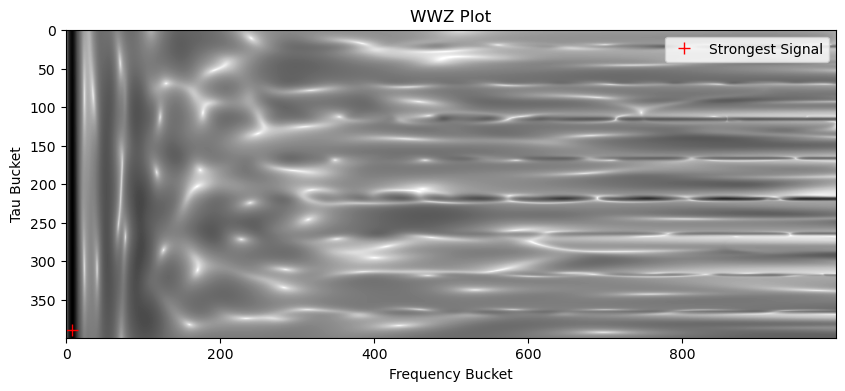

In [362]:
min_trunc_factor = 1000
plt.title("WWZ Plot")
plt.xlabel("Frequency Bucket")
plt.ylabel("Tau Bucket")
#plt.figure().set_figwidth(12)
implot = plt.imshow(result_wwz, cmap=cmap, norm=LogNorm(vmin=result_wwz.min()*min_trunc_factor, vmax=result_wwz.max()))
plt.plot([j], [i], c='red', marker='+', ms=8, label="Strongest Signal");
plt.legend()
plt.show()
pass

In [337]:
pd.DataFrame(result_wwz.flatten()).describe()

,0
count,400000.000000
mean,10.709798
std,66.332982
min,0.000001
25%,1.001199
50%,2.559343
75%,5.580825
max,1232.042245


## Plot the WWA

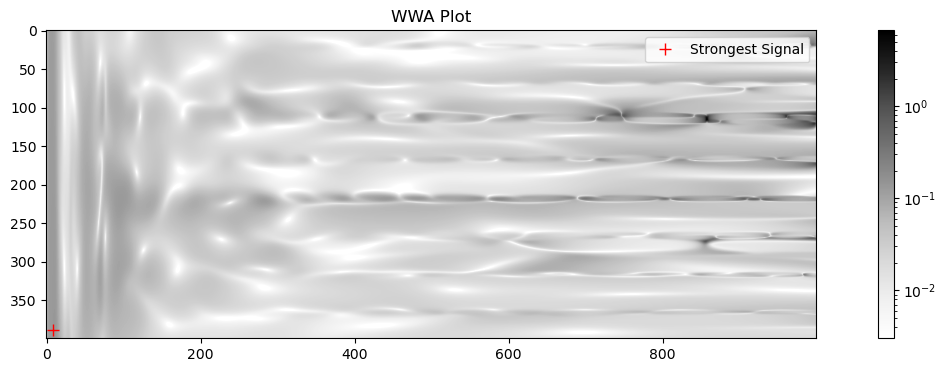

In [366]:
min_trunc_factor = 100
plt.title("WWA Plot")
img = plt.imshow(result_wwa, cmap=cmap, norm=LogNorm(vmin=result_wwa.min()*min_trunc_factor, vmax=result_wwa.max()))
plt.colorbar(img)
plt.plot([j], [i], c='red', marker='+', ms=8, label="Strongest Signal");
plt.legend()
plt.show()
pass

In [340]:
pd.DataFrame(result_wwa.flatten()).describe()


,0
count,400000.000000
mean,0.032686
std,0.047073
min,0.000030
25%,0.014257
50%,0.023638
75%,0.038978
max,6.692497
